<a href="https://colab.research.google.com/github/MaxShelestiuk/testrep/blob/master/C3W4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4: Predicting the next word

Welcome to this assignment! During this week you saw how to create a model that will predict the next word in a text sequence, now you will implement such model and train it using a corpus of Shakespeare's sonnets, while also creating some helper functions to pre-process the data.


Let's get started!

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

For this assignment you will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2022-12-12 06:01:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.003s  

2022-12-12 06:01:01 (28.1 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len -1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(.2))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           321100    
                                                                 
 bidirectional (Bidirectiona  (None, 10, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1605)              483105    
                                                                 
 dense_1 (Dense)             (None, 3211)              5

## Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [5]:
history = model.fit(predictors, label, epochs=20, verbose=1)

Epoch 1/20
484/484 [==============================] - 16s 12ms/step - loss: 7.0248 - accuracy: 0.0222
Epoch 2/20
484/484 [==============================] - 6s 12ms/step - loss: 6.5218 - accuracy: 0.0223
Epoch 3/20
484/484 [==============================] - 5s 11ms/step - loss: 6.4123 - accuracy: 0.0268
Epoch 4/20
484/484 [==============================] - 6s 13ms/step - loss: 6.2863 - accuracy: 0.0341
Epoch 5/20
484/484 [==============================] - 6s 13ms/step - loss: 6.1604 - accuracy: 0.0379
Epoch 6/20
484/484 [==============================] - 8s 16ms/step - loss: 6.0304 - accuracy: 0.0382
Epoch 7/20
484/484 [==============================] - 7s 15ms/step - loss: 5.8966 - accuracy: 0.0463
Epoch 8/20
484/484 [==============================] - 6s 13ms/step - loss: 5.7645 - accuracy: 0.0537
Epoch 9/20
484/484 [==============================] - 5s 11ms/step - loss: 5.6321 - accuracy: 0.0632
Epoch 10/20
484/484 [==============================] - 5s 11ms/step - loss: 5.5010 - accur

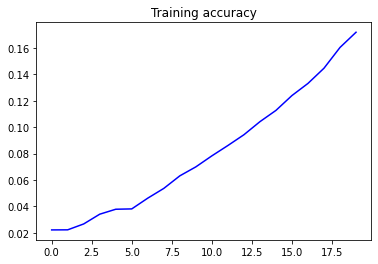

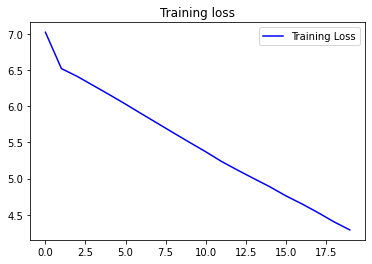

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

If you pass this text directly into the `texts_to_sequences` method you will get an unexpected result:

In [7]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope is his mind to show his deeds away his ground light light light light night ' lust and seen stol'n in heaven's faces ' there are seen dyed heaven's tomb to stand open discontent did burn in night days light light light night ' lust by night so ride ' seen open air and men ' seen lust so night to light light light light ' to stand weeds rage and so gone by your deeds doth lie to every deeds to ill ' now lie to every face it be my love doth lie to my heart to thine
